In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
%matplotlib inline

In [2]:
api_calls_day = pd.Timestamp('2019-06-13')
churn_cutoff = api_calls_day - pd.Timedelta(3,'M')

In [3]:
df_friend_summary = pd.read_csv('200k_friend_summary.csv',dtype={'steamid': int}).drop('Unnamed: 0',axis='columns')
df_friend_summary_up = pd.read_csv('200k_friend_num_up.csv',dtype={'steamid': int}).drop('Unnamed: 0',axis='columns')
df_profile_summary = pd.read_csv('200k_clean_player_info.csv',dtype={'steamid': int}).drop('Unnamed: 0',axis='columns')
df_per_game_summary = pd.read_csv('200k_per_game.csv',dtype={'steamid': int}).drop('Unnamed: 0',axis='columns')
df_game_per_user_summary = pd.read_csv('200k_game_per_user.csv',dtype={'steamid': int}).drop('Unnamed: 0',axis='columns')
df_top5game_per_user_summary = pd.read_csv('200k_top5game_per_user.csv',dtype={'steamid': int}).drop('Unnamed: 0',axis='columns')

In [4]:
df_full_prof = df_friend_summary.merge(df_profile_summary,on='steamid',how='right')

In [5]:
df_full_prof = df_full_prof.merge(df_friend_summary_up,on='steamid',how='left')

In [6]:
df_full_prof.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 177203 entries, 0 to 177202
Data columns (total 23 columns):
num_Friends              170877 non-null float64
steamid                  177203 non-null int64
newest_friend_time       170877 non-null float64
newest_friend_steamid    170877 non-null float64
oldest_friend_time       170877 non-null float64
oldest_friend_steamid    170877 non-null float64
commentpermission        91987 non-null float64
lastlogoff               177058 non-null float64
loccityid                47596 non-null float64
loccountrycode           133204 non-null object
locstatecode             81788 non-null object
personaname              177194 non-null object
profilestate             176380 non-null float64
realname                 112688 non-null object
timecreated              177203 non-null float64
costom_avatar            177203 non-null int64
isPublic                 177203 non-null int64
isFriendsOnly            177203 non-null int64
isPrivate             

In [7]:
df_full_prof[df_full_prof['num_Friends_up'] == df_full_prof['num_Friends']]['steamid'].nunique()

2427

In [8]:
df_full_prof = df_full_prof.merge(df_game_per_user_summary,on='steamid',how='left')

In [9]:
#df_full_prof.fillna(0,inplace=True)

In [10]:
print(churn_cutoff)

2019-03-13 16:32:42


In [11]:
import datetime
pd.to_datetime((churn_cutoff - datetime.datetime(1970, 1, 1)).total_seconds(), unit='s')

Timestamp('2019-03-13 16:32:42')

In [12]:
df_full_prof['isChurned'] = df_full_prof['lastlogoff'].map(lambda x: 1 if (pd.to_datetime(x, unit='s') < churn_cutoff) else 0)


In [13]:
df_friend_full = pd.read_csv('player_friend_info_200k.csv',dtype={'steamid': int}).drop('Unnamed: 0',axis='columns')

In [14]:
df_friend_full = df_friend_full[pd.to_datetime(df_friend_full['friend_since'], unit='s') < churn_cutoff]

In [15]:
df_friend_large = pd.merge(df_friend_full,df_full_prof,on='steamid')

In [16]:
df_friend_large = df_friend_large.drop(['relationship','friend_since','newest_friend_time','oldest_friend_time','lastlogoff','profilestate','timecreated','isPublic','isFriendsOnly','isPrivate','playtime_forever_max','playtime_forever_std','playtime_forever_std_noZero'],axis='columns')


In [17]:
df_friends_list = pd.DataFrame(df_friend_large.groupby('steamid_orig')['steamid'].apply(list))

In [18]:
df_friends_list = df_friends_list.add_suffix('_friend_list')
df_friends_list = df_friends_list.reset_index()
df_friends_list['steamid'] = df_friends_list['steamid_orig']
df_friends_list = df_friends_list.drop('steamid_orig',axis='columns')

In [19]:
df_friends_mean = pd.DataFrame(df_friend_large.drop(['steamid','appid_max'],axis='columns').groupby('steamid_orig').mean())

In [20]:
df_friends_mean = df_friends_mean.add_suffix('_friends_mean')

In [21]:
df_friends_mean = df_friends_mean.reset_index()
df_friends_mean['steamid'] = df_friends_mean['steamid_orig']
df_friends_mean = df_friends_mean.drop('steamid_orig',axis='columns')

In [22]:
df_friends_mode = pd.DataFrame(df_friend_large[df_friend_large['appid_max'] != 0].groupby('steamid_orig')['appid_max'].apply(pd.Series.mode))

In [23]:
df_friends_mode = df_friends_mode.reset_index().drop('level_1',axis='columns')
df_friends_mode['steamid'] = df_friends_mode['steamid_orig']
df_friends_mode['friends_fav_appid'] = df_friends_mode['appid_max']
df_friends_mode = df_friends_mode.drop('steamid_orig',axis='columns')
df_friends_mode = df_friends_mode.drop('appid_max',axis='columns')
df_friends_mode = df_friends_mode.drop_duplicates(['steamid'],keep='first')
df_friends_mode.info()
print(df_friends_mode['steamid'].nunique())
print(df_friends_mean['steamid'].nunique())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 134200 entries, 0 to 211754
Data columns (total 2 columns):
steamid              134200 non-null int64
friends_fav_appid    134200 non-null float64
dtypes: float64(1), int64(1)
memory usage: 3.1 MB
134200
169445


In [24]:
df_friends_stats = pd.merge(df_friends_mean,df_friends_mode,on='steamid',how='outer')

In [25]:
df_friends_temp = df_full_prof.merge(df_friends_stats,on='steamid',how='left')

In [26]:
df_friends_temp['steamid'].nunique()

177203

In [27]:
df_dup_steamid = df_friends_temp[df_friends_temp.duplicated(['steamid'],keep=False)]

In [28]:
df_dup_steamid

,num_Friends,steamid,newest_friend_time,newest_friend_steamid,oldest_friend_time,oldest_friend_steamid,commentpermission,lastlogoff,loccityid,loccountrycode,...,costom_avatar_friends_mean,inClan_friends_mean,num_Friends_up_friends_mean,playtime_forever_sum_friends_mean,appid_count_friends_mean,playtime_forever_mean_friends_mean,appid_count_noZero_friends_mean,playtime_forever_mean_noZero_friends_mean,isChurned_friends_mean,friends_fav_appid


In [29]:
#df_friends_temp.fillna(0,inplace=True)

In [30]:
df_friends_temp['Same_fav_as_friend'] = df_friends_temp.apply(lambda x: 1 if x['appid_max'] == x['friends_fav_appid'] else 0,axis=1)

In [31]:
df_friends_temp['num_Zero_games'] = df_friends_temp['appid_count'] - df_friends_temp['appid_count_noZero']

In [32]:
df_full_prof = df_friends_temp

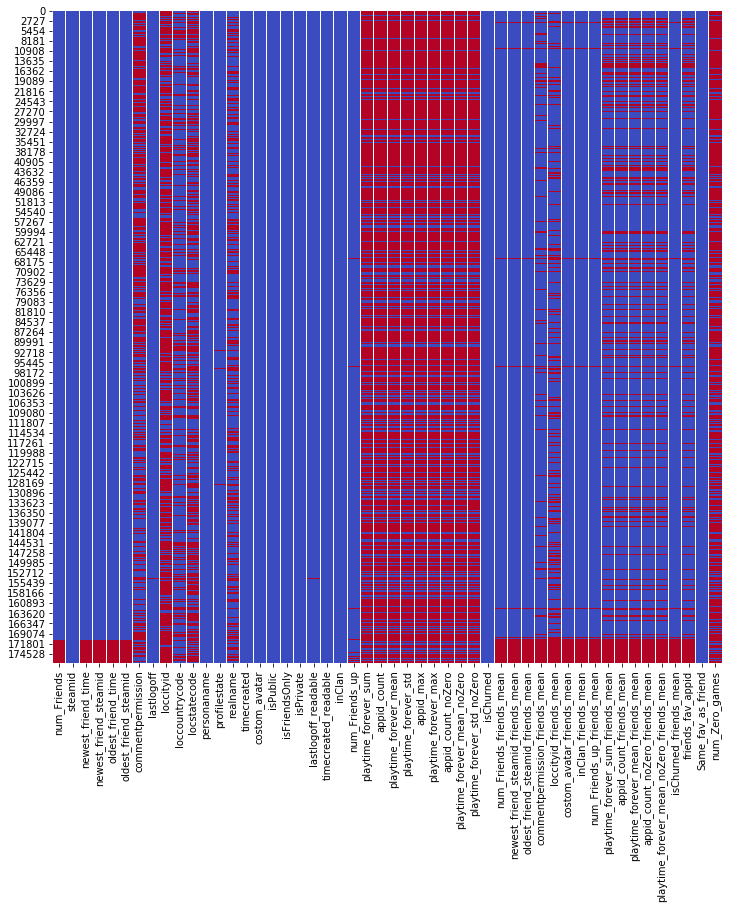

In [33]:
axis = plt.figure(figsize=(12,12))
sns.heatmap(df_full_prof.isna(),cmap='coolwarm',cbar=False)

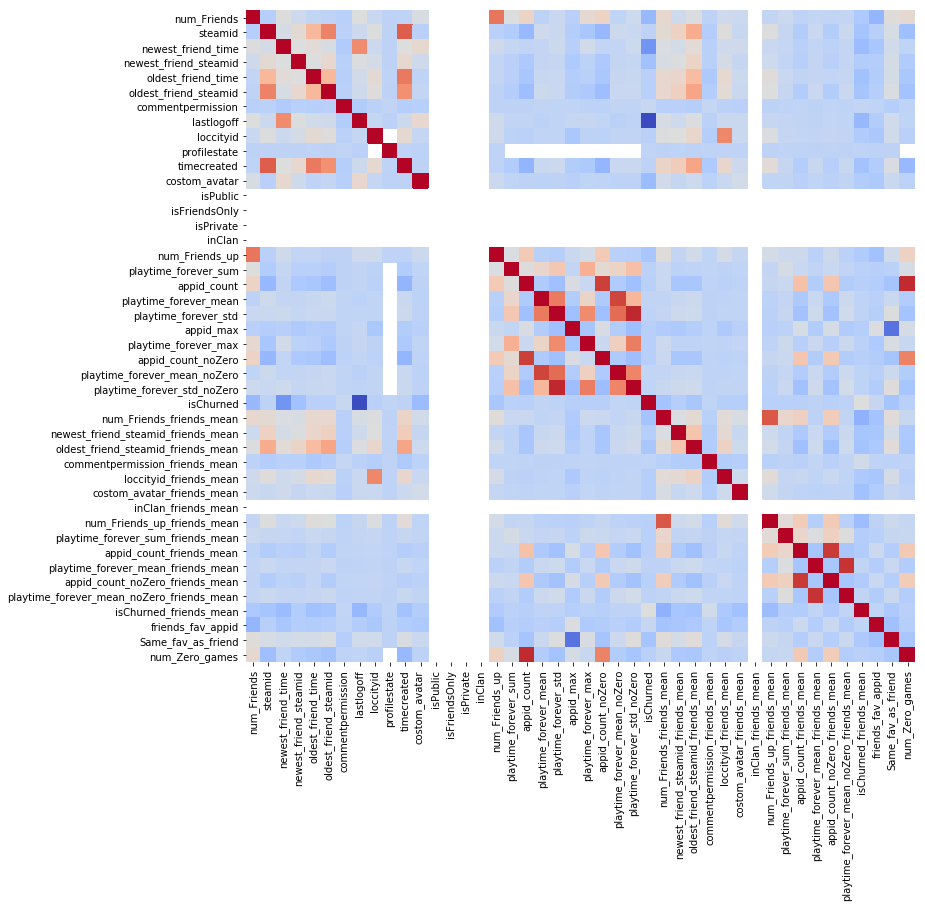

In [34]:
axis = plt.figure(figsize=(12,12))
sns.heatmap(df_full_prof.corr(),cmap='coolwarm',cbar=False)

In [35]:
df_full_prof = df_full_prof.drop(['newest_friend_steamid','oldest_friend_steamid','loccityid','isPublic','isFriendsOnly','isPrivate','inClan','appid_max','newest_friend_steamid_friends_mean','oldest_friend_steamid_friends_mean','loccityid_friends_mean'],axis='columns')

In [36]:
df_full_prof.corrwith(df_full_prof['isChurned'])

num_Friends                                 -0.187683
steamid                                     -0.001936
newest_friend_time                          -0.366085
oldest_friend_time                          -0.026058
commentpermission                            0.049958
lastlogoff                                  -0.652837
profilestate                                 0.009159
timecreated                                 -0.001589
costom_avatar                               -0.172291
num_Friends_up                              -0.105780
playtime_forever_sum                        -0.016284
appid_count                                 -0.032842
playtime_forever_mean                        0.017493
playtime_forever_std                         0.005050
playtime_forever_max                        -0.034373
appid_count_noZero                          -0.038195
playtime_forever_mean_noZero                 0.022848
playtime_forever_std_noZero                  0.007425
isChurned                   

In [37]:
df_full_prof = df_full_prof.drop(['locstatecode','personaname','realname','lastlogoff_readable','timecreated_readable','appid_count','playtime_forever_mean','playtime_forever_std','commentpermission_friends_mean','inClan_friends_mean','playtime_forever_mean_friends_mean','playtime_forever_mean_noZero_friends_mean','friends_fav_appid'],axis='columns')

In [38]:
print(df_full_prof.columns)

Index(['num_Friends', 'steamid', 'newest_friend_time', 'oldest_friend_time',
       'commentpermission', 'lastlogoff', 'loccountrycode', 'profilestate',
       'timecreated', 'costom_avatar', 'num_Friends_up',
       'playtime_forever_sum', 'playtime_forever_max', 'appid_count_noZero',
       'playtime_forever_mean_noZero', 'playtime_forever_std_noZero',
       'isChurned', 'num_Friends_friends_mean', 'costom_avatar_friends_mean',
       'num_Friends_up_friends_mean', 'playtime_forever_sum_friends_mean',
       'appid_count_friends_mean', 'appid_count_noZero_friends_mean',
       'isChurned_friends_mean', 'Same_fav_as_friend', 'num_Zero_games'],
      dtype='object')


In [39]:
df_full_prof['loccountrycode'].value_counts().head(10)

US    28937
RU    10873
JP     9507
DE     8431
GB     7162
BR     6616
CA     5205
CN     4578
AU     3290
FR     2397
Name: loccountrycode, dtype: int64

In [40]:
#df_test = pd.concat([df_full_prof,pd.get_dummies(df_full_prof['loccountrycode'])[['US','JP','RU','DE','GB','BR','CA','CN','AU','FR']]],axis=1)

In [41]:
#df_test.corrwith(df_full_prof['isChurned'])

In [42]:
df_full_prof = df_full_prof.drop(['loccountrycode'],axis='columns')

In [43]:
df_full_prof.columns

Index(['num_Friends', 'steamid', 'newest_friend_time', 'oldest_friend_time',
       'commentpermission', 'lastlogoff', 'profilestate', 'timecreated',
       'costom_avatar', 'num_Friends_up', 'playtime_forever_sum',
       'playtime_forever_max', 'appid_count_noZero',
       'playtime_forever_mean_noZero', 'playtime_forever_std_noZero',
       'isChurned', 'num_Friends_friends_mean', 'costom_avatar_friends_mean',
       'num_Friends_up_friends_mean', 'playtime_forever_sum_friends_mean',
       'appid_count_friends_mean', 'appid_count_noZero_friends_mean',
       'isChurned_friends_mean', 'Same_fav_as_friend', 'num_Zero_games'],
      dtype='object')

In [44]:
df_full_prof.isna().sum()

num_Friends                            6326
steamid                                   0
newest_friend_time                     6326
oldest_friend_time                     6326
commentpermission                     85216
lastlogoff                              145
profilestate                            823
timecreated                               0
costom_avatar                             0
num_Friends_up                         1682
playtime_forever_sum                 127689
playtime_forever_max                 127689
appid_count_noZero                   127689
playtime_forever_mean_noZero         127689
playtime_forever_std_noZero          127948
isChurned                                 0
num_Friends_friends_mean               7806
costom_avatar_friends_mean             7758
num_Friends_up_friends_mean            7758
playtime_forever_sum_friends_mean     43003
appid_count_friends_mean              43003
appid_count_noZero_friends_mean       43003
isChurned_friends_mean          

In [45]:
df_full_prof.mean()

num_Friends                          1.341822e+02
steamid                              7.656120e+16
newest_friend_time                   1.520883e+09
oldest_friend_time                   1.188668e+09
commentpermission                    1.058019e+00
lastlogoff                           1.550029e+09
profilestate                         1.000023e+00
timecreated                          1.322352e+09
costom_avatar                        9.631553e-01
num_Friends_up                       2.455344e+01
playtime_forever_sum                 3.879583e+05
playtime_forever_max                 9.020506e+04
appid_count_noZero                   3.325005e+02
playtime_forever_mean_noZero         3.785829e+03
playtime_forever_std_noZero          1.137805e+04
isChurned                            1.552965e-01
num_Friends_friends_mean             3.047145e+02
costom_avatar_friends_mean           9.880362e-01
num_Friends_up_friends_mean          1.305309e+02
playtime_forever_sum_friends_mean    5.984207e+05


In [46]:
df_full_prof['num_Friends'] = df_full_prof['num_Friends'].fillna(df_full_prof['num_Friends'].mean())

In [47]:
df_full_prof['oldest_friend_time'] = df_full_prof['oldest_friend_time'].replace(0,df_full_prof['timecreated'])
df_full_prof['newest_friend_time'] = df_full_prof['newest_friend_time'].replace(0,df_full_prof['timecreated'])


In [48]:
df_full_prof['duration_till_newest_Friend'] = df_full_prof['newest_friend_time'] - df_full_prof['timecreated']

In [49]:
df_full_prof['duration_till_oldest_Friend'] = df_full_prof['oldest_friend_time'] - df_full_prof['timecreated']

In [50]:
df_full_prof.mean()

num_Friends                          1.341822e+02
steamid                              7.656120e+16
newest_friend_time                   1.524216e+09
oldest_friend_time                   1.349968e+09
commentpermission                    1.058019e+00
lastlogoff                           1.550029e+09
profilestate                         1.000023e+00
timecreated                          1.322352e+09
costom_avatar                        9.631553e-01
num_Friends_up                       2.455344e+01
playtime_forever_sum                 3.879583e+05
playtime_forever_max                 9.020506e+04
appid_count_noZero                   3.325005e+02
playtime_forever_mean_noZero         3.785829e+03
playtime_forever_std_noZero          1.137805e+04
isChurned                            1.552965e-01
num_Friends_friends_mean             3.047145e+02
costom_avatar_friends_mean           9.880362e-01
num_Friends_up_friends_mean          1.305309e+02
playtime_forever_sum_friends_mean    5.984207e+05


In [51]:
df_full_prof['oldest_friend_time'].fillna(df_full_prof['duration_till_oldest_Friend'].mean()+df_full_prof['timecreated'],inplace=True)
df_full_prof['newest_friend_time'].fillna(df_full_prof['duration_till_newest_Friend'].mean()+df_full_prof['timecreated'],inplace=True)


In [52]:
df_full_prof = df_full_prof[pd.to_datetime(df_full_prof['oldest_friend_time'], unit='s') < churn_cutoff]
df_full_prof = df_full_prof[pd.to_datetime(df_full_prof['newest_friend_time'], unit='s') < churn_cutoff]
df_full_prof.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 173910 entries, 0 to 177201
Data columns (total 27 columns):
num_Friends                          173910 non-null float64
steamid                              173910 non-null int64
newest_friend_time                   173910 non-null float64
oldest_friend_time                   173910 non-null float64
commentpermission                    89866 non-null float64
lastlogoff                           173769 non-null float64
profilestate                         173095 non-null float64
timecreated                          173910 non-null float64
costom_avatar                        173910 non-null int64
num_Friends_up                       172541 non-null float64
playtime_forever_sum                 48259 non-null float64
playtime_forever_max                 48259 non-null float64
appid_count_noZero                   48259 non-null float64
playtime_forever_mean_noZero         48259 non-null float64
playtime_forever_std_noZero          48023 n

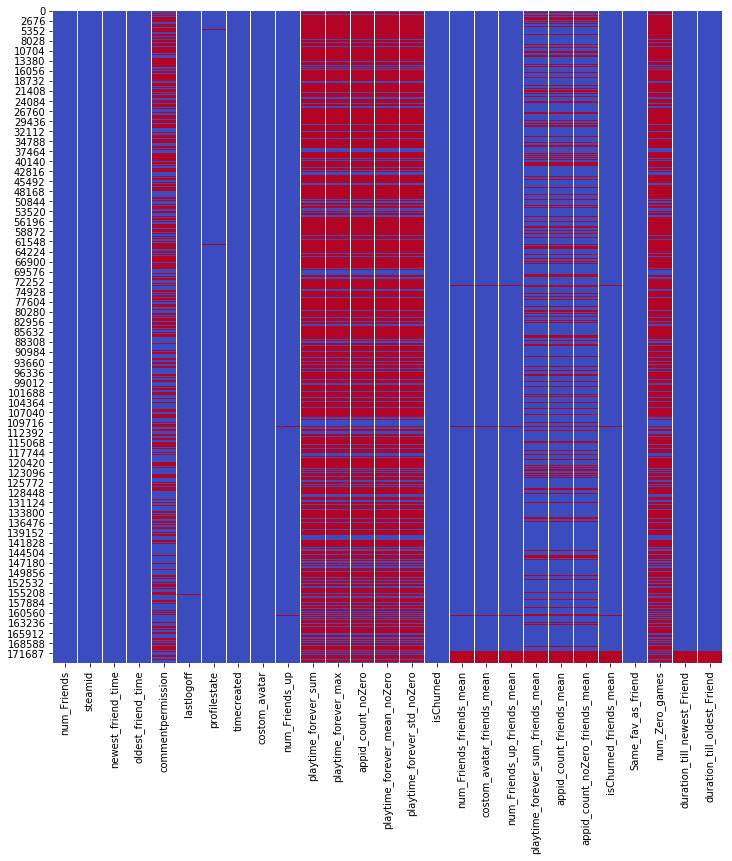

In [53]:
axis = plt.figure(figsize=(12,12))
sns.heatmap(df_full_prof.isna(),cmap='coolwarm',cbar=False)

In [54]:
df_full_prof['commentpermission'].fillna(0,inplace=True)

In [55]:
df_full_prof.dropna(subset=['lastlogoff'],inplace=True)

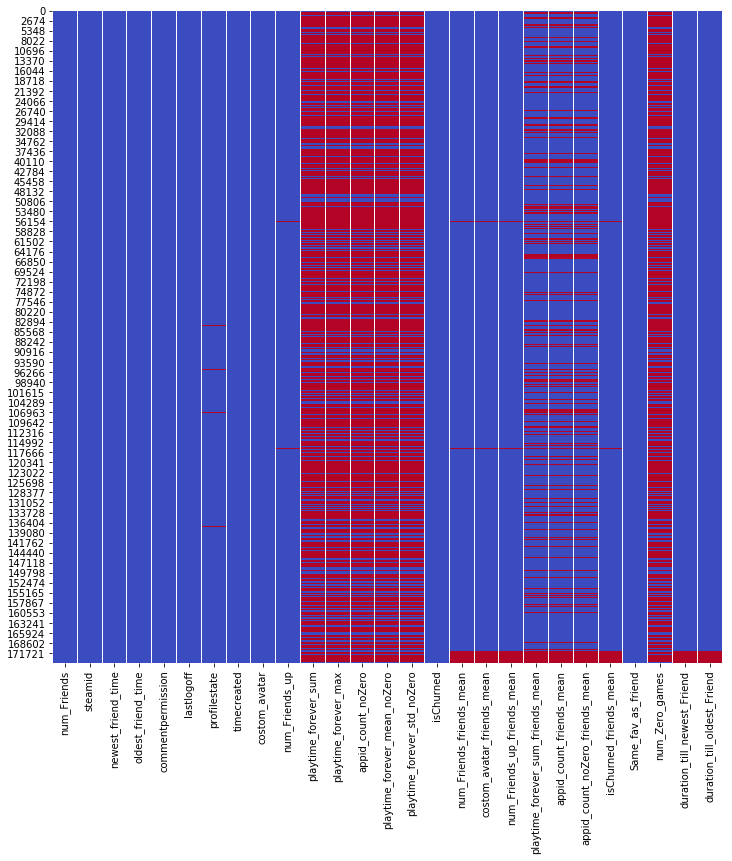

In [56]:
axis = plt.figure(figsize=(12,12))
sns.heatmap(df_full_prof.isna(),cmap='coolwarm',cbar=False)

In [57]:
df_full_prof.isna().sum()

num_Friends                               0
steamid                                   0
newest_friend_time                        0
oldest_friend_time                        0
commentpermission                         0
lastlogoff                                0
profilestate                            751
timecreated                               0
costom_avatar                             0
num_Friends_up                         1368
playtime_forever_sum                 125510
playtime_forever_max                 125510
appid_count_noZero                   125510
playtime_forever_mean_noZero         125510
playtime_forever_std_noZero          125746
isChurned                                 0
num_Friends_friends_mean               4512
costom_avatar_friends_mean             4464
num_Friends_up_friends_mean            4464
playtime_forever_sum_friends_mean     39647
appid_count_friends_mean              39647
appid_count_noZero_friends_mean       39647
isChurned_friends_mean          

In [58]:
df_full_prof['profilestate'].fillna(0,inplace=True)

In [59]:
df_full_prof['num_Friends_up'].fillna(df_full_prof['num_Friends_up'].mean(),inplace=True)

In [60]:
df_full_prof = df_full_prof.drop(['duration_till_newest_Friend','duration_till_oldest_Friend'],axis='columns')

In [61]:
df_full_prof.isna().sum()

num_Friends                               0
steamid                                   0
newest_friend_time                        0
oldest_friend_time                        0
commentpermission                         0
lastlogoff                                0
profilestate                              0
timecreated                               0
costom_avatar                             0
num_Friends_up                            0
playtime_forever_sum                 125510
playtime_forever_max                 125510
appid_count_noZero                   125510
playtime_forever_mean_noZero         125510
playtime_forever_std_noZero          125746
isChurned                                 0
num_Friends_friends_mean               4512
costom_avatar_friends_mean             4464
num_Friends_up_friends_mean            4464
playtime_forever_sum_friends_mean     39647
appid_count_friends_mean              39647
appid_count_noZero_friends_mean       39647
isChurned_friends_mean          

In [62]:
import math as math

df_full_prof['appid_count_noZero'].fillna(math.floor(df_full_prof['appid_count_noZero'].mean()),inplace=True)
df_full_prof['num_Zero_games'].fillna(math.floor(df_full_prof['num_Zero_games'].mean()),inplace=True)




In [63]:
df_full_prof.isna().sum()

num_Friends                               0
steamid                                   0
newest_friend_time                        0
oldest_friend_time                        0
commentpermission                         0
lastlogoff                                0
profilestate                              0
timecreated                               0
costom_avatar                             0
num_Friends_up                            0
playtime_forever_sum                 125510
playtime_forever_max                 125510
appid_count_noZero                        0
playtime_forever_mean_noZero         125510
playtime_forever_std_noZero          125746
isChurned                                 0
num_Friends_friends_mean               4512
costom_avatar_friends_mean             4464
num_Friends_up_friends_mean            4464
playtime_forever_sum_friends_mean     39647
appid_count_friends_mean              39647
appid_count_noZero_friends_mean       39647
isChurned_friends_mean          

In [64]:
df_full_prof=df_full_prof.fillna(df_full_prof.mean())

In [65]:
df_churned = df_full_prof[df_full_prof['isChurned'] == 1]

In [66]:
df_active = df_full_prof[df_full_prof['isChurned'] == 0]

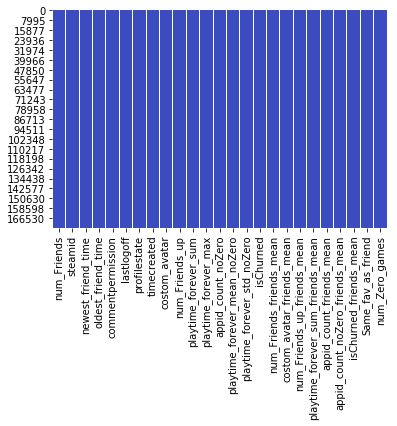

In [67]:
sns.heatmap(df_active.isna(),cmap='coolwarm',cbar=False)

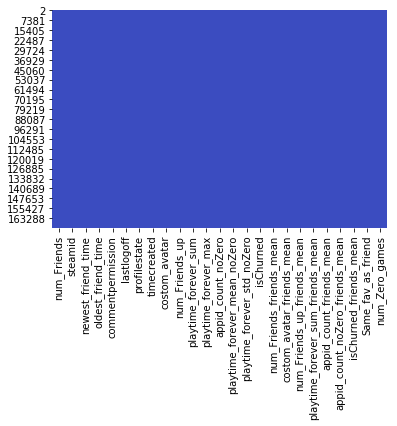

In [68]:
sns.heatmap(df_churned.isna(),cmap='coolwarm',cbar=False)

In [69]:
from sklearn.model_selection import train_test_split
df_churned_train, df_churned_test = train_test_split(df_churned,test_size=0.2,random_state=1234)

In [70]:
df_active_remain, df_active_test = train_test_split(df_active,test_size=0.2,random_state=1234)

In [71]:
df_active_extra, df_active_train = train_test_split(df_active_remain,test_size=len(df_churned_train),random_state=1234)

In [72]:
df_train = pd.concat([df_active_train,df_churned_train])

In [73]:
df_test = pd.concat([df_active_test,df_churned_test])

In [74]:
X_train = df_train.drop(['steamid','lastlogoff','isChurned','isChurned_friends_mean','playtime_forever_max','playtime_forever_sum_friends_mean','costom_avatar_friends_mean','appid_count_friends_mean'],axis='columns')
X_test = df_test.drop(['steamid','lastlogoff','isChurned','isChurned_friends_mean','playtime_forever_max','playtime_forever_sum_friends_mean','costom_avatar_friends_mean','appid_count_friends_mean'],axis='columns')
y_train = df_train['isChurned']
y_test = df_test['isChurned']

In [75]:
X_train.columns

Index(['num_Friends', 'newest_friend_time', 'oldest_friend_time',
       'commentpermission', 'profilestate', 'timecreated', 'costom_avatar',
       'num_Friends_up', 'playtime_forever_sum', 'appid_count_noZero',
       'playtime_forever_mean_noZero', 'playtime_forever_std_noZero',
       'num_Friends_friends_mean', 'num_Friends_up_friends_mean',
       'appid_count_noZero_friends_mean', 'Same_fav_as_friend',
       'num_Zero_games'],
      dtype='object')

In [76]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

In [77]:
log_model = LogisticRegression(random_state=10,solver='lbfgs',C=0.1)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

/anaconda2/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda2/lib/python3.6/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda2/lib/python3.6/site-packages/ipykernel_launcher.py:4: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  after removing the cwd from sys.path.


In [78]:
log_model.fit(X_train_scaled,y_train)

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=10, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

# Validate

[[19113  2859]
 [ 6093 15879]]


              precision    recall  f1-score   support

           0       0.76      0.87      0.81     21972
           1       0.85      0.72      0.78     21972

   micro avg       0.80      0.80      0.80     43944
   macro avg       0.80      0.80      0.80     43944
weighted avg       0.80      0.80      0.80     43944



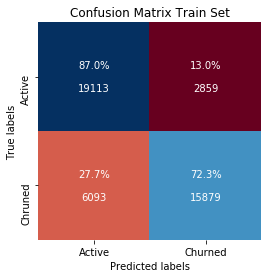

In [79]:
from sklearn.metrics import confusion_matrix, classification_report
axis = plt.figure(figsize=(4,4))
log_pred = log_model.predict(X_train_scaled)
cm = confusion_matrix(y_train,log_pred)
cm_perc = cm.astype('float64') / cm.sum(axis=1)[:, np.newaxis]
annot = np.empty_like(cm).astype(str)
nrows, ncols = cm.shape
for i in range(nrows):
    for j in range(ncols):
        c = cm[i, j]
        p = cm_perc[i, j]
        annot[i, j] = '%.1f%%\n\n%d' % (p*100, c)
ax = plt.subplot()
sns.heatmap(cm_perc, annot=annot, fmt='',ax = ax,cmap='RdBu',cbar=False)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix Train Set')
ax.xaxis.set_ticklabels(['Active', 'Churned'])
ax.yaxis.set_ticklabels(['Active', 'Chruned'])
print(cm)
print('\n')
print(classification_report(y_train,log_pred))

[[25423  3838]
 [ 1501  3992]]


              precision    recall  f1-score   support

           0       0.94      0.87      0.90     29261
           1       0.51      0.73      0.60      5493

   micro avg       0.85      0.85      0.85     34754
   macro avg       0.73      0.80      0.75     34754
weighted avg       0.88      0.85      0.86     34754



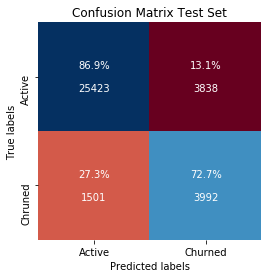

In [80]:
axis = plt.figure(figsize=(4,4))
log_pred = log_model.predict(X_test_scaled)
cm = confusion_matrix(y_test,log_pred)
cm_perc = cm.astype('float64') / cm.sum(axis=1)[:, np.newaxis]
annot = np.empty_like(cm).astype(str)
nrows, ncols = cm.shape
for i in range(nrows):
    for j in range(ncols):
        c = cm[i, j]
        p = cm_perc[i, j]
        annot[i, j] = '%.1f%%\n\n%d' % (p*100, c)
ax = plt.subplot()
sns.heatmap(cm_perc, annot=annot, fmt='',ax = ax,cmap='RdBu',cbar=False)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix Test Set')
ax.xaxis.set_ticklabels(['Active', 'Churned'])
ax.yaxis.set_ticklabels(['Active', 'Chruned'])
print(cm)
print('\n')
print(classification_report(y_test,log_pred))

In [81]:
df_train['Prob_Churn'] = log_model.predict_proba(X_train_scaled)[:,1]
df_test['Prob_Churn'] = log_model.predict_proba(X_test_scaled)[:,1]

[[19416  2556]
 [ 6589 15383]]


              precision    recall  f1-score   support

           0       0.75      0.88      0.81     21972
           1       0.86      0.70      0.77     21972

   micro avg       0.79      0.79      0.79     43944
   macro avg       0.80      0.79      0.79     43944
weighted avg       0.80      0.79      0.79     43944



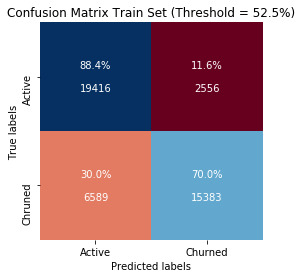

In [82]:
#confusion matrix with custom threshold
axis = plt.figure(figsize=(4,4))
log_pred = df_train['Prob_Churn'] > 0.525
cm = confusion_matrix(y_train,log_pred)
cm_perc = cm.astype('float64') / cm.sum(axis=1)[:, np.newaxis]
annot = np.empty_like(cm).astype(str)
nrows, ncols = cm.shape
for i in range(nrows):
    for j in range(ncols):
        c = cm[i, j]
        p = cm_perc[i, j]
        annot[i, j] = '%.1f%%\n\n%d' % (p*100, c)
ax = plt.subplot()
sns.heatmap(cm_perc, annot=annot, fmt='',ax = ax,cmap='RdBu',cbar=False)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix Train Set (Threshold = 52.5%)')
ax.xaxis.set_ticklabels(['Active', 'Churned'])
ax.yaxis.set_ticklabels(['Active', 'Chruned'])
print(cm)
print('\n')
print(classification_report(y_train,log_pred))

[[25810  3451]
 [ 1634  3859]]


              precision    recall  f1-score   support

           0       0.94      0.88      0.91     29261
           1       0.53      0.70      0.60      5493

   micro avg       0.85      0.85      0.85     34754
   macro avg       0.73      0.79      0.76     34754
weighted avg       0.88      0.85      0.86     34754



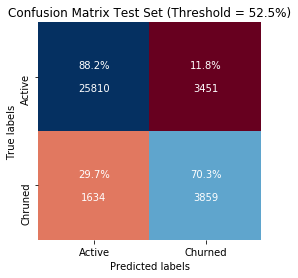

In [83]:
#confusion matrix with custom threshold
axis = plt.figure(figsize=(4,4))
log_pred = df_test['Prob_Churn'] > 0.525
cm = confusion_matrix(y_test,log_pred)
cm_perc = cm.astype('float64') / cm.sum(axis=1)[:, np.newaxis]
annot = np.empty_like(cm).astype(str)
nrows, ncols = cm.shape
for i in range(nrows):
    for j in range(ncols):
        c = cm[i, j]
        p = cm_perc[i, j]
        annot[i, j] = '%.1f%%\n\n%d' % (p*100, c)
ax = plt.subplot()
sns.heatmap(cm_perc, annot=annot, fmt='',ax = ax,cmap='RdBu',cbar=False)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix Test Set (Threshold = 52.5%)')
ax.xaxis.set_ticklabels(['Active', 'Churned'])
ax.yaxis.set_ticklabels(['Active', 'Chruned'])
print(cm)
print('\n')
print(classification_report(y_test,log_pred))

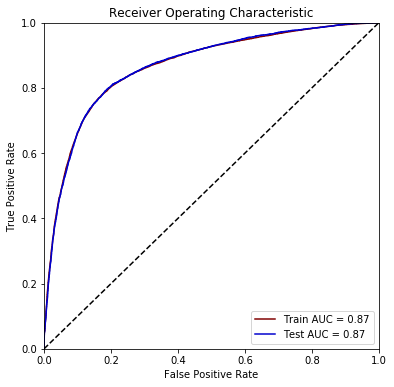

In [84]:
from sklearn import metrics
fpr_train, tpr_train, threshold_train = metrics.roc_curve(y_train, df_train['Prob_Churn'], pos_label=1)
roc_auc_train = metrics.auc(fpr_train, tpr_train)
fpr_test, tpr_test, threshold_test = metrics.roc_curve(y_test, df_test['Prob_Churn'], pos_label=1)
roc_auc_test = metrics.auc(fpr_test, tpr_test)

# method I: plt
axis = plt.figure(figsize=(6,6))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr_train, tpr_train, 'maroon',label = 'Train AUC = %0.2f' % roc_auc_train)
plt.plot(fpr_test, tpr_test, 'mediumblue',label = 'Test AUC = %0.2f' % roc_auc_test)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'k--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

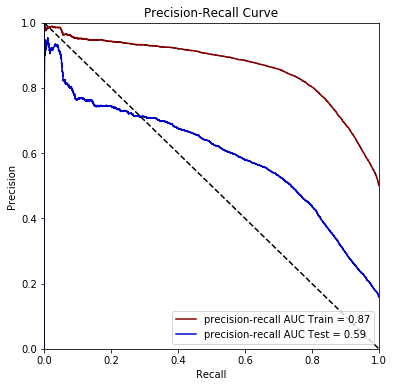

In [85]:
precision_train, recall_train, threshold_train = metrics.precision_recall_curve(y_train, df_train['Prob_Churn'], pos_label=1)
roc_auc_train = metrics.auc(recall_train, precision_train)
precision_test, recall_test, threshold_test = metrics.precision_recall_curve(y_test, df_test['Prob_Churn'], pos_label=1)
roc_auc_test = metrics.auc(recall_test, precision_test)

# method I: plt
axis = plt.figure(figsize=(6,6))
plt.title('Precision-Recall Curve')
plt.plot(recall_train, precision_train, 'maroon', label = 'precision-recall AUC Train = %0.2f' % roc_auc_train)
plt.plot(recall_test, precision_test, 'mediumblue', label = 'precision-recall AUC Test = %0.2f' % roc_auc_test)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [1, 0],'k--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

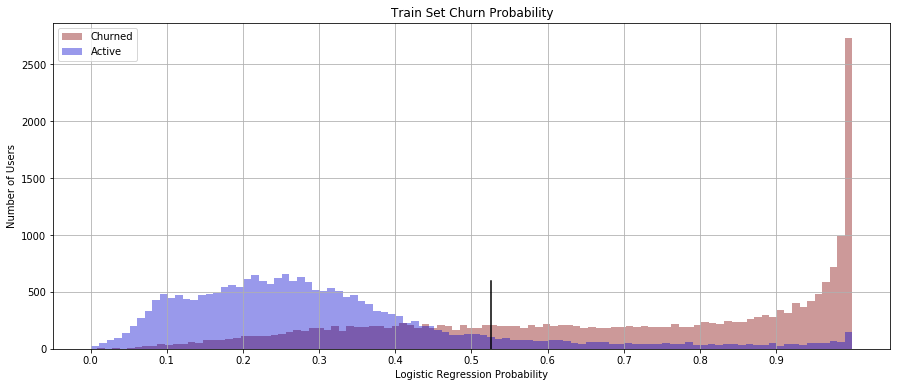

In [86]:
axis = plt.figure(figsize=(15,6))
plt.grid(which='major',axis='both')
plt.xticks(np.arange(0, 1, step=0.1))
sns.distplot( df_train['Prob_Churn'][df_train['isChurned'] == 1] , color="maroon", label="Churned",bins=100,kde=False)
sns.distplot( df_train['Prob_Churn'][df_train['isChurned'] == 0] , color="mediumblue", label="Active",bins=100,kde=False)
plt.legend()
plt.plot([0.525, 0.525], [0, 600],'k')
plt.ylabel("Number of Users")
plt.xlabel("Logistic Regression Probability")
plt.title("Train Set Churn Probability")
plt.show()

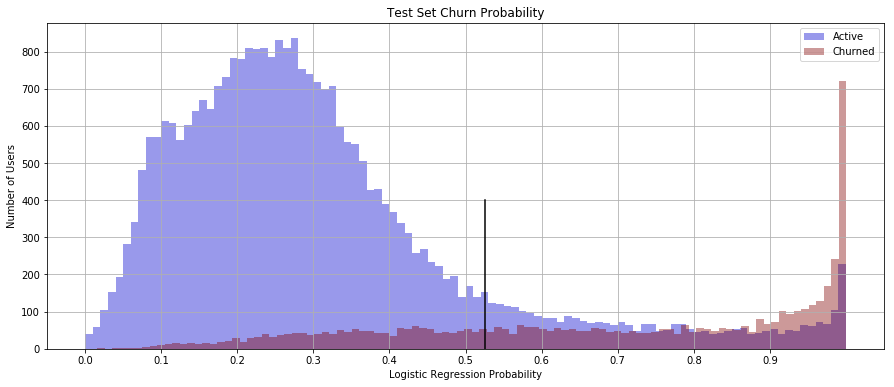

In [87]:
axis = plt.figure(figsize=(15,6))
plt.grid(which='major',axis='both')
plt.xticks(np.arange(0, 1, step=0.1))
sns.distplot( df_test['Prob_Churn'][df_test['isChurned'] == 0] , color="mediumblue", label="Active",bins=100,kde=False)
sns.distplot( df_test['Prob_Churn'][df_test['isChurned'] == 1] , color="maroon", label="Churned",bins=100,kde=False)
plt.legend()
plt.plot([0.525, 0.525], [0, 400],'k')
plt.ylabel("Number of Users")
plt.xlabel("Logistic Regression Probability")
plt.title("Test Set Churn Probability")
plt.show()

In [88]:
feature_dict = {}
for i in range(0,len(log_model.coef_[0])):
    feature_dict[X_train.columns[i]] = abs(log_model.coef_[0][i])

In [89]:
import operator
features_sorted = sorted(feature_dict.items(), key=operator.itemgetter(1),reverse=True)

In [90]:
for i in features_sorted:
    print(i)

('newest_friend_time', 2.29039898668791)
('oldest_friend_time', 0.3120316228649892)
('Same_fav_as_friend', 0.2794859129040635)
('num_Friends_up', 0.1913131539846922)
('timecreated', 0.17225226440261562)
('num_Friends_friends_mean', 0.16365965569536373)
('num_Friends_up_friends_mean', 0.10265102584000271)
('costom_avatar', 0.07968860398119966)
('appid_count_noZero_friends_mean', 0.07685689594841306)
('num_Friends', 0.06053771149480424)
('playtime_forever_mean_noZero', 0.04479342030675868)
('profilestate', 0.044031014239996204)
('playtime_forever_std_noZero', 0.03948777792919868)
('num_Zero_games', 0.02918852119324798)
('commentpermission', 0.020328823968042878)
('playtime_forever_sum', 0.020102527297234794)
('appid_count_noZero', 0.01364849532825434)


# Tune Regularizaion parameter

In [91]:
from sklearn.metrics import balanced_accuracy_score, accuracy_score

In [92]:
my_Cs = [0.001,0.003,0.01,0.03,0.1,0.3,1.0]
bal_acc_test = []
bal_acc_train = []
acc_test = []
acc_train = []
for C in my_Cs:
    log_model = LogisticRegression(random_state=10,solver='lbfgs',C=C)
    log_model.fit(X_train_scaled,y_train)
    y_pred_test = log_model.predict(X_test_scaled)
    y_pred_train = log_model.predict(X_train_scaled)
    bal_acc_test.append(balanced_accuracy_score(y_pred_test,y_test))
    bal_acc_train.append(balanced_accuracy_score(y_pred_train,y_train))
    acc_test.append(accuracy_score(y_pred_test,y_test))
    acc_train.append(accuracy_score(y_pred_train,y_train))

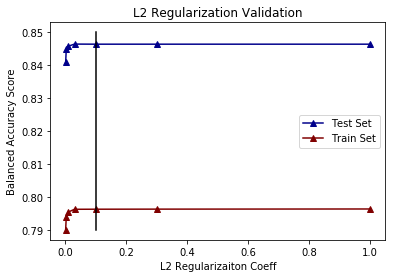

In [93]:
plt.plot(my_Cs, acc_test,color='darkblue',marker='^',label='Test Set')
plt.plot(my_Cs, acc_train,color='maroon',marker='^',label='Train Set')
plt.legend()
plt.plot([0.1, 0.1], [0.79, 0.85],'k')
plt.ylabel("Balanced Accuracy Score")
plt.xlabel("L2 Regularizaiton Coeff")
plt.title("L2 Regularization Validation")
plt.show()

# Learning curve

In [94]:
my_fracs = [0.001,0.01,0.05,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.99]
learning_train = []
learning_test = []
bal_learning_train = []
bal_learning_test = []
for frac in my_fracs:
    log_model = LogisticRegression(random_state=10,solver='lbfgs',C=0.1)
    X_train_scaled_extra, X_train_scaled_frac, y_train_extra, y_train_frac = train_test_split(X_train_scaled,y_train,test_size=frac,shuffle=True,stratify=y_train)
    log_model.fit(X_train_scaled_frac,y_train_frac)
    y_pred_test = log_model.predict(X_test_scaled)
    y_pred_train = log_model.predict(X_train_scaled_frac)
    bal_learning_test.append(balanced_accuracy_score(y_pred_test,y_test))
    bal_learning_train.append(balanced_accuracy_score(y_pred_train,y_train_frac))
    learning_test.append(accuracy_score(y_pred_test,y_test))
    learning_train.append(accuracy_score(y_pred_train,y_train_frac))
    
    

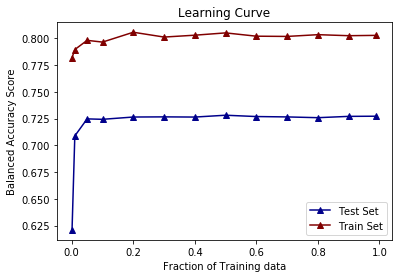

In [95]:
plt.plot(my_fracs, bal_learning_test,color='darkblue',marker='^',label='Test Set')
plt.plot(my_fracs, bal_learning_train,color='maroon',marker='^',label='Train Set')
plt.legend()
plt.ylabel("Balanced Accuracy Score")
plt.xlabel("Fraction of Training data")
plt.title("Learning Curve")
plt.show()

# Calculate Average Prob of Friends

In [96]:
df_friend_full.head()

,friend_since,relationship,steamid,steamid_orig
0,1434524498,friend,76561198007070703,76561198199710782
1,1437740667,friend,76561198041503217,76561198199710782
2,1438264541,friend,76561198238259518,76561198199710782
3,1421677696,friend,76561197960448312,76561198049785932
4,1490267324,friend,76561197961426758,76561198049785932


In [97]:
X_full_scaled = scaler.transform(df_full_prof[X_train.columns])
df_full_prof['Prob_Churned'] = log_model.predict_proba(X_full_scaled)[:,1]

/anaconda2/lib/python3.6/site-packages/ipykernel_launcher.py:1: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  """Entry point for launching an IPython kernel.


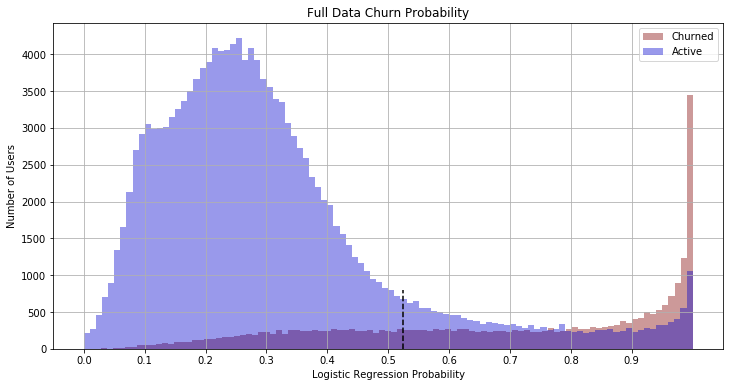

In [98]:
axis = plt.figure(figsize=(12,6))
plt.grid(which='major',axis='both')
plt.xticks(np.arange(0, 1, step=0.1))
sns.distplot( df_full_prof['Prob_Churned'][df_full_prof['isChurned'] == 1] , color="maroon", label="Churned",bins=100,kde=False)
sns.distplot( df_full_prof['Prob_Churned'][df_full_prof['isChurned'] == 0] , color="mediumblue", label="Active",bins=100,kde=False)
plt.legend()
plt.plot([0.525, 0.525], [0, 800],'k--')
plt.ylabel("Number of Users")
plt.xlabel("Logistic Regression Probability")
plt.title("Full Data Churn Probability")
plt.show()

[[0.88069362 0.11930638]
 [0.29965411 0.70034589]]


              precision    recall  f1-score   support

           0       0.94      0.88      0.91    146304
           1       0.52      0.70      0.60     27465

   micro avg       0.85      0.85      0.85    173769
   macro avg       0.73      0.79      0.75    173769
weighted avg       0.87      0.85      0.86    173769



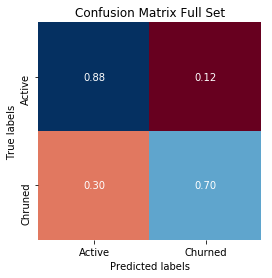

In [99]:
axis = plt.figure(figsize=(4,4))
log_pred = df_full_prof['Prob_Churned'] > 0.525
cm = confusion_matrix(df_full_prof['isChurned'],log_pred)
cm = cm.astype('float64') / cm.sum(axis=1)[:, np.newaxis]
ax = plt.subplot()
sns.heatmap(cm, annot=True, fmt='0.2f',ax = ax,cmap='RdBu',cbar=False)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix Full Set')
ax.xaxis.set_ticklabels(['Active', 'Churned'])
ax.yaxis.set_ticklabels(['Active', 'Chruned'])
print(cm)
print('\n')
print(classification_report(df_full_prof['isChurned'],log_pred))

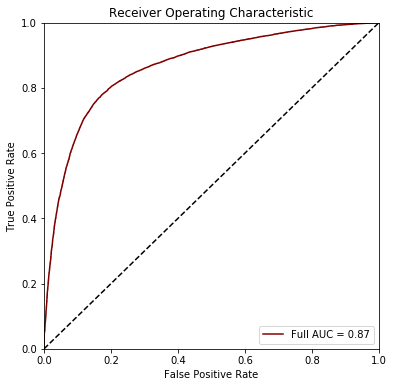

In [100]:
fpr_full, tpr_full, threshold_full = metrics.roc_curve(df_full_prof['isChurned'], df_full_prof['Prob_Churned'], pos_label=1)
roc_auc_full = metrics.auc(fpr_full, tpr_full)

# method I: plt
axis = plt.figure(figsize=(6,6))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr_train, tpr_train, 'maroon',label = 'Full AUC = %0.2f' % roc_auc_full)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'k--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [101]:
df_friend_prob = pd.merge(df_friend_full,df_full_prof[['steamid','Prob_Churned']],on='steamid')

In [102]:
df_friend_prob.head()

,friend_since,relationship,steamid,steamid_orig,Prob_Churned
0,1434524498,friend,76561198007070703,76561198199710782,0.098569
1,1455556043,friend,76561198007070703,76561198119327769,0.098569
2,1488713631,friend,76561198007070703,76561198302636934,0.098569
3,1424045974,friend,76561198007070703,76561198035000472,0.098569
4,1403982908,friend,76561198007070703,76561198022371464,0.098569


In [103]:
df_friend_prob = df_friend_prob.drop(['friend_since','relationship'],axis='columns')

In [104]:
df_friends_prob_mean = pd.DataFrame(df_friend_prob.drop(['steamid'],axis='columns').groupby('steamid_orig').mean())

In [105]:
df_friends_prob_mean.head()

,Prob_Churned
steamid_orig,
76561197960265730,0.184848
76561197960265731,0.306349
76561197960265733,0.301395
76561197960265738,0.387596
76561197960265743,0.472538


In [106]:
df_friends_prob_mean = df_friends_prob_mean.add_suffix('_friends_mean')

In [107]:
df_friends_prob_mean = df_friends_prob_mean.reset_index()
df_friends_prob_mean['steamid'] = df_friends_prob_mean['steamid_orig']
df_friends_prob_mean = df_friends_prob_mean.drop('steamid_orig',axis='columns')

In [108]:
df_friends_prob_mean.head()

,Prob_Churned_friends_mean,steamid
0,0.184848,76561197960265730
1,0.306349,76561197960265731
2,0.301395,76561197960265733
3,0.387596,76561197960265738
4,0.472538,76561197960265743


In [109]:
df_friends_big = df_full_prof.merge(df_friends_prob_mean,on='steamid',how='left')

In [110]:
df_friends_big.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 173769 entries, 0 to 173768
Data columns (total 27 columns):
num_Friends                          173769 non-null float64
steamid                              173769 non-null int64
newest_friend_time                   173769 non-null float64
oldest_friend_time                   173769 non-null float64
commentpermission                    173769 non-null float64
lastlogoff                           173769 non-null float64
profilestate                         173769 non-null float64
timecreated                          173769 non-null float64
costom_avatar                        173769 non-null int64
num_Friends_up                       173769 non-null float64
playtime_forever_sum                 173769 non-null float64
playtime_forever_max                 173769 non-null float64
appid_count_noZero                   173769 non-null float64
playtime_forever_mean_noZero         173769 non-null float64
playtime_forever_std_noZero          17

In [111]:
df_friends_big[['isChurned_friends_mean','Prob_Churned_friends_mean','isChurned','Prob_Churned']].corr()

,isChurned_friends_mean,Prob_Churned_friends_mean,isChurned,Prob_Churned
isChurned_friends_mean,1.000000,0.539469,0.169393,0.192167
Prob_Churned_friends_mean,0.539469,1.000000,0.153427,0.252182
isChurned,0.169393,0.153427,1.000000,0.550773
Prob_Churned,0.192167,0.252182,0.550773,1.000000


# Recalculate Prob after feature changes

In [112]:
X_new_friend = df_friends_big.drop(['steamid','lastlogoff','isChurned','isChurned_friends_mean','playtime_forever_max','playtime_forever_sum_friends_mean','costom_avatar_friends_mean','appid_count_friends_mean','Prob_Churned_friends_mean','Prob_Churned'],axis='columns')
X_play_owned_game = df_friends_big.drop(['steamid','lastlogoff','isChurned','isChurned_friends_mean','playtime_forever_max','playtime_forever_sum_friends_mean','costom_avatar_friends_mean','appid_count_friends_mean','Prob_Churned_friends_mean','Prob_Churned'],axis='columns')
X_communityprofile = df_friends_big.drop(['steamid','lastlogoff','isChurned','isChurned_friends_mean','playtime_forever_max','playtime_forever_sum_friends_mean','costom_avatar_friends_mean','appid_count_friends_mean','Prob_Churned_friends_mean','Prob_Churned'],axis='columns')
X_customavatar = df_friends_big.drop(['steamid','lastlogoff','isChurned','isChurned_friends_mean','playtime_forever_max','playtime_forever_sum_friends_mean','costom_avatar_friends_mean','appid_count_friends_mean','Prob_Churned_friends_mean','Prob_Churned'],axis='columns')
X_allowcomments = df_friends_big.drop(['steamid','lastlogoff','isChurned','isChurned_friends_mean','playtime_forever_max','playtime_forever_sum_friends_mean','costom_avatar_friends_mean','appid_count_friends_mean','Prob_Churned_friends_mean','Prob_Churned'],axis='columns')
X_same_fav_as_friend = df_friends_big.drop(['steamid','lastlogoff','isChurned','isChurned_friends_mean','playtime_forever_max','playtime_forever_sum_friends_mean','costom_avatar_friends_mean','appid_count_friends_mean','Prob_Churned_friends_mean','Prob_Churned'],axis='columns')
X_play_0p05_more = df_friends_big.drop(['steamid','lastlogoff','isChurned','isChurned_friends_mean','playtime_forever_max','playtime_forever_sum_friends_mean','costom_avatar_friends_mean','appid_count_friends_mean','Prob_Churned_friends_mean','Prob_Churned'],axis='columns')


In [113]:
X_new_friend['num_Friends'] += 1
X_new_friend['num_Friends_up'] += 1
X_new_friend = X_new_friend.assign(newest_friend_time=(churn_cutoff - datetime.datetime(1970, 1, 1)).total_seconds())

In [114]:
X_new_friend_scaled = scaler.transform(X_new_friend)
df_friends_big['Add_Friend'] = log_model.predict_proba(X_new_friend_scaled)[:,1]

/anaconda2/lib/python3.6/site-packages/ipykernel_launcher.py:1: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  """Entry point for launching an IPython kernel.


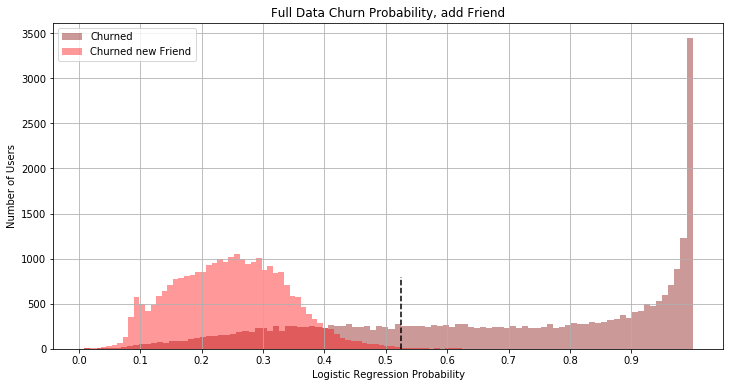

In [115]:
axis = plt.figure(figsize=(12,6))
plt.grid(which='major',axis='both')
plt.xticks(np.arange(0, 1, step=0.1))
sns.distplot( df_friends_big['Prob_Churned'][df_friends_big['isChurned'] == 1] , color="maroon", label="Churned",bins=100,kde=False)
#sns.distplot( df_friends_big['Prob_Churned'][df_friends_big['isChurned'] == 0] , color="mediumblue", label="Active",bins=100,kde=False)
sns.distplot( df_friends_big['Add_Friend'][df_friends_big['isChurned'] == 1] , color="red", label="Churned new Friend",bins=100,kde=False)
#sns.distplot( df_friends_big['Add_Friend'][df_friends_big['isChurned'] == 0] , color="blue", label="Active new Friend",bins=100,kde=False)
plt.legend()
plt.plot([0.525, 0.525], [0, 800],'k--')
plt.ylabel("Number of Users")
plt.xlabel("Logistic Regression Probability")
plt.title("Full Data Churn Probability, add Friend")
plt.show()

In [116]:
X_play_owned_game['num_Zero_games'] -= 1
X_play_owned_game['num_Friends_up'] += 1
X_play_owned_game['num_Zero_games'] = X_play_owned_game['num_Zero_games'].apply(lambda x: x if x >= -1 else 0)

In [117]:
X_play_owned_game_scaled = scaler.transform(X_play_owned_game)
df_friends_big['Play_Owned_Game'] = log_model.predict_proba(X_play_owned_game_scaled)[:,1]

/anaconda2/lib/python3.6/site-packages/ipykernel_launcher.py:1: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  """Entry point for launching an IPython kernel.


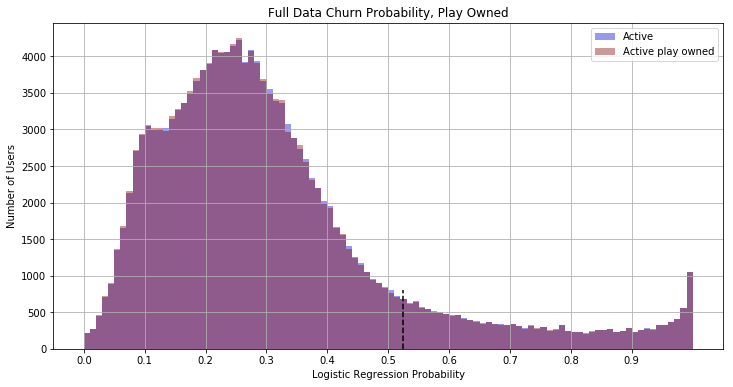

In [118]:
axis = plt.figure(figsize=(12,6))
plt.grid(which='major',axis='both')
plt.xticks(np.arange(0, 1, step=0.1))
#sns.distplot( df_friends_big['Prob_Churned'][df_friends_big['isChurned'] == 1] , color="maroon", label="Churned",bins=100,kde=False)
sns.distplot( df_friends_big['Prob_Churned'][df_friends_big['isChurned'] == 0] , color="mediumblue", label="Active",bins=100,kde=False)
#sns.distplot( df_friends_big['Play_Owned_Game'][df_friends_big['isChurned'] == 1] , color="maroon", label="Churned play owned",bins=100,kde=False)
sns.distplot( df_friends_big['Play_Owned_Game'][df_friends_big['isChurned'] == 0] , color="maroon", label="Active play owned",bins=100,kde=False)
plt.legend()
plt.plot([0.525, 0.525], [0, 800],'k--')
plt.ylabel("Number of Users")
plt.xlabel("Logistic Regression Probability")
plt.title("Full Data Churn Probability, Play Owned")
plt.show()

In [119]:
X_communityprofile = X_communityprofile.assign(profilestate=1)

In [120]:
X_communityprofile_scaled = scaler.transform(X_communityprofile)
df_friends_big['Community_Profile'] = log_model.predict_proba(X_communityprofile_scaled)[:,1]

/anaconda2/lib/python3.6/site-packages/ipykernel_launcher.py:1: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  """Entry point for launching an IPython kernel.


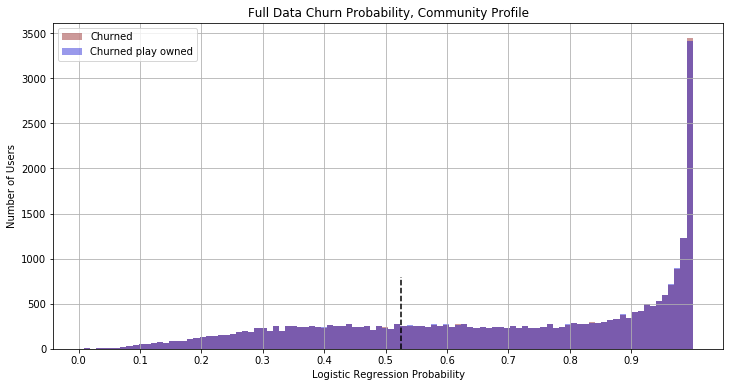

In [121]:
axis = plt.figure(figsize=(12,6))
plt.grid(which='major',axis='both')
plt.xticks(np.arange(0, 1, step=0.1))
sns.distplot( df_friends_big['Prob_Churned'][df_friends_big['isChurned'] == 1] , color="maroon", label="Churned",bins=100,kde=False)
#sns.distplot( df_friends_big['Prob_Churned'][df_friends_big['isChurned'] == 0] , color="mediumblue", label="Active",bins=100,kde=False)
sns.distplot( df_friends_big['Community_Profile'][df_friends_big['isChurned'] == 1] , color="mediumblue", label="Churned play owned",bins=100,kde=False)
#sns.distplot( df_friends_big['Community_Profile'][df_friends_big['isChurned'] == 0] , color="maroon", label="Active play owned",bins=100,kde=False)
plt.legend()
plt.plot([0.525, 0.525], [0, 800],'k--')
plt.ylabel("Number of Users")
plt.xlabel("Logistic Regression Probability")
plt.title("Full Data Churn Probability, Community Profile")
plt.show()

In [122]:
X_customavatar = X_customavatar.assign(costom_avatar=1)

In [123]:
X_customavatar_scaled = scaler.transform(X_customavatar)
df_friends_big['Custom_Avatar'] = log_model.predict_proba(X_customavatar_scaled)[:,1]

/anaconda2/lib/python3.6/site-packages/ipykernel_launcher.py:1: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  """Entry point for launching an IPython kernel.


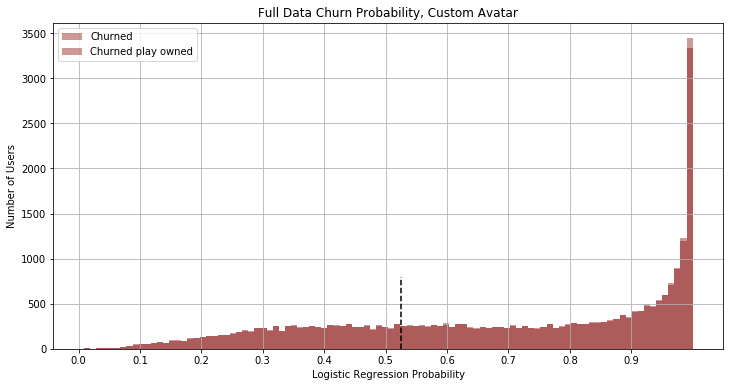

In [124]:
axis = plt.figure(figsize=(12,6))
plt.grid(which='major',axis='both')
plt.xticks(np.arange(0, 1, step=0.1))
sns.distplot( df_friends_big['Prob_Churned'][df_friends_big['isChurned'] == 1] , color="maroon", label="Churned",bins=100,kde=False)
#sns.distplot( df_friends_big['Prob_Churned'][df_friends_big['isChurned'] == 0] , color="mediumblue", label="Active",bins=100,kde=False)
sns.distplot( df_friends_big['Custom_Avatar'][df_friends_big['isChurned'] == 1] , color="maroon", label="Churned play owned",bins=100,kde=False)
#sns.distplot( df_friends_big['Custom_Avatar'][df_friends_big['isChurned'] == 0] , color="maroon", label="Active Custom Avatar",bins=100,kde=False)
plt.legend()
plt.plot([0.525, 0.525], [0, 800],'k--')
plt.ylabel("Number of Users")
plt.xlabel("Logistic Regression Probability")
plt.title("Full Data Churn Probability, Custom Avatar")
plt.show()

In [125]:
X_allowcomments = X_allowcomments.assign(commentpermission=1)

In [126]:
X_allowcomments_scaled = scaler.transform(X_allowcomments)
df_friends_big['Allow_Comments'] = log_model.predict_proba(X_allowcomments_scaled)[:,1]

/anaconda2/lib/python3.6/site-packages/ipykernel_launcher.py:1: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  """Entry point for launching an IPython kernel.


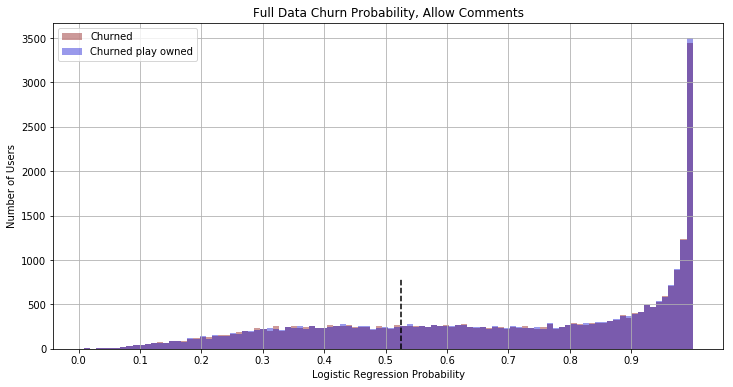

In [127]:
axis = plt.figure(figsize=(12,6))
plt.grid(which='major',axis='both')
plt.xticks(np.arange(0, 1, step=0.1))
sns.distplot( df_friends_big['Prob_Churned'][df_friends_big['isChurned'] == 1] , color="maroon", label="Churned",bins=100,kde=False)
#sns.distplot( df_friends_big['Prob_Churned'][df_friends_big['isChurned'] == 0] , color="mediumblue", label="Active",bins=100,kde=False)
sns.distplot( df_friends_big['Allow_Comments'][df_friends_big['isChurned'] == 1] , color="mediumblue", label="Churned play owned",bins=100,kde=False)
#sns.distplot( df_friends_big['Allow_Comments'][df_friends_big['isChurned'] == 0] , color="maroon", label="Active allow comments",bins=100,kde=False)
plt.legend()
plt.plot([0.525, 0.525], [0, 800],'k--')
plt.ylabel("Number of Users")
plt.xlabel("Logistic Regression Probability")
plt.title("Full Data Churn Probability, Allow Comments")
plt.show()

In [128]:
X_same_fav_as_friend = X_same_fav_as_friend.assign(Same_fav_as_friend=1)

In [129]:
X_same_fav_as_friend_scaled = scaler.transform(X_same_fav_as_friend)
df_friends_big['Same_Fave_Prob'] = log_model.predict_proba(X_same_fav_as_friend_scaled)[:,1]

/anaconda2/lib/python3.6/site-packages/ipykernel_launcher.py:1: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  """Entry point for launching an IPython kernel.


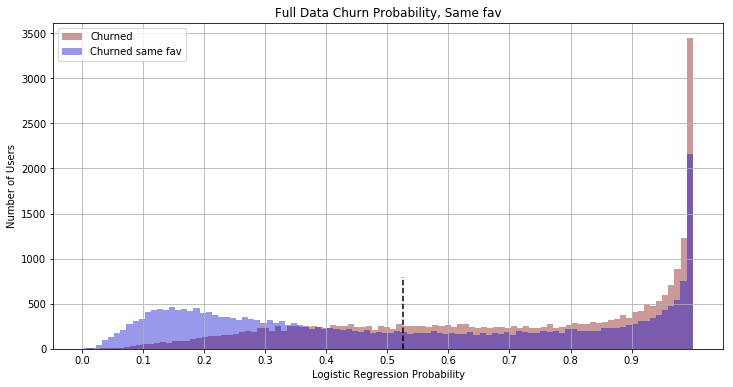

In [130]:
axis = plt.figure(figsize=(12,6))
plt.grid(which='major',axis='both')
plt.xticks(np.arange(0, 1, step=0.1))
sns.distplot( df_friends_big['Prob_Churned'][df_friends_big['isChurned'] == 1] , color="maroon", label="Churned",bins=100,kde=False)
#sns.distplot( df_friends_big['Prob_Churned'][df_friends_big['isChurned'] == 0] , color="mediumblue", label="Active",bins=100,kde=False)
sns.distplot( df_friends_big['Same_Fave_Prob'][df_friends_big['isChurned'] == 1] , color="mediumblue", label="Churned same fav",bins=100,kde=False)
#sns.distplot( df_friends_big['Same_Fave_Prob'][df_friends_big['isChurned'] == 0] , color="maroon", label="Active same fav",bins=100,kde=False)
plt.legend()
plt.plot([0.525, 0.525], [0, 800],'k--')
plt.ylabel("Number of Users")
plt.xlabel("Logistic Regression Probability")
plt.title("Full Data Churn Probability, Same fav")
plt.show()

In [131]:
X_play_0p05_more['playtime_forever_sum'] *= 1.05

In [132]:
X_play_0p05_more_scaled = scaler.transform(X_play_0p05_more)
df_friends_big['Play_0p05_more'] = log_model.predict_proba(X_play_0p05_more_scaled)[:,1]

/anaconda2/lib/python3.6/site-packages/ipykernel_launcher.py:1: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  """Entry point for launching an IPython kernel.


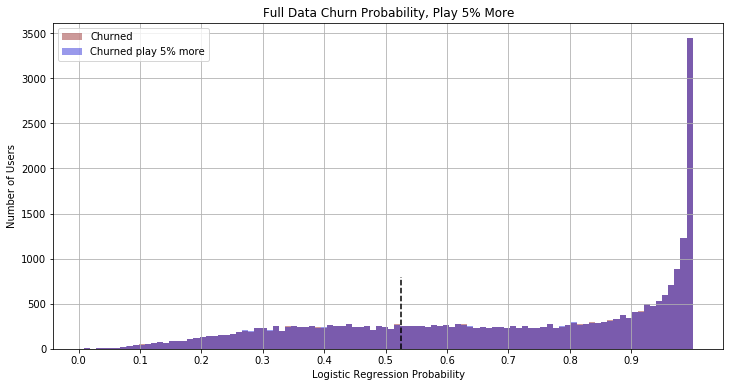

In [133]:
axis = plt.figure(figsize=(12,6))
plt.grid(which='major',axis='both')
plt.xticks(np.arange(0, 1, step=0.1))
sns.distplot( df_friends_big['Prob_Churned'][df_friends_big['isChurned'] == 1] , color="maroon", label="Churned",bins=100,kde=False)
#sns.distplot( df_friends_big['Prob_Churned'][df_friends_big['isChurned'] == 0] , color="mediumblue", label="Active",bins=100,kde=False)
sns.distplot( df_friends_big['Play_0p05_more'][df_friends_big['isChurned'] == 1] , color="mediumblue", label="Churned play 5% more",bins=100,kde=False)
#sns.distplot( df_friends_big['Play_0p05_more'][df_friends_big['isChurned'] == 0] , color="maroon", label="Active play 20hr",bins=100,kde=False)
plt.legend()
plt.plot([0.525, 0.525], [0, 800],'k--')
plt.ylabel("Number of Users")
plt.xlabel("Logistic Regression Probability")
plt.title("Full Data Churn Probability, Play 5% More")
plt.show()

In [134]:
df_friends_small = df_friends_big[['steamid','Prob_Churned', 'Prob_Churned_friends_mean', 'Add_Friend', 'Play_Owned_Game','Community_Profile','Custom_Avatar','Allow_Comments','Same_Fave_Prob','Play_0p05_more']]


In [135]:
as_dict =  .set_index('steamid').to_dict()

SyntaxError: invalid syntax (<ipython-input-135-80732887c86f>, line 1)

In [136]:
import psycopg2

In [137]:
try:
    connection = psycopg2.connect(user = "cmart",
                                  host = "127.0.0.1",
                                  port = "5432",
                                  database = "SteamChurn_200k")
    cursor = connection.cursor()
    # Print PostgreSQL Connection properties
    print ( connection.get_dsn_parameters(),"\n")
    # Print PostgreSQL version
    cursor.execute("SELECT version();")
    record = cursor.fetchone()
    print("You are connected to - ", record,"\n")
except (Exception, psycopg2.Error) as error :
    print ("Error while connecting to PostgreSQL", error)
finally:
    #closing database connection.
        if(connection):
            cursor.close()
            connection.close()
            print("PostgreSQL connection is closed")

{'user': 'cmart', 'passfile': '/Users/cmart/.pgpass', 'dbname': 'SteamChurn_200k', 'host': '127.0.0.1', 'port': '5432', 'tty': '', 'options': '', 'sslmode': 'prefer', 'sslcompression': '0', 'krbsrvname': 'postgres', 'target_session_attrs': 'any'} 

You are connected to -  ('PostgreSQL 11.3 on x86_64-apple-darwin16.7.0, compiled by Apple LLVM version 8.1.0 (clang-802.0.42), 64-bit',) 

PostgreSQL connection is closed


In [ ]:
from psycopg2 import Error
try:
    connection = psycopg2.connect(user = "cmart",
                                  host = "127.0.0.1",
                                  port = "5432",
                                  database = "SteamChurn_200k")
    cursor = connection.cursor()
    
    create_table_query = '''CREATE TABLE users (
          steamid bigint,
          Prob_Churned float,
          Prob_Churned_friends_mean float,
          Add_Friend float,
          Play_Owned_Game float,
          Community_Profile float,
          Custom_Avatar float,
          Allow_Comments float,
          Same_Fave_Prob float,
          Play_0p05_more float,
          CONSTRAINT persons_pkey PRIMARY KEY (steamid)
          ); '''
    
    cursor.execute(create_table_query)
    connection.commit()
    print("Table created successfully in PostgreSQL ")
except (Exception, psycopg2.DatabaseError) as error :
    print ("Error while creating PostgreSQL table", error)
finally:
    #closing database connection.
        if(connection):
            cursor.close()
            connection.close()
            print("PostgreSQL connection is closed")

In [ ]:
try:
    connection = psycopg2.connect(user = "cmart",
                                  host = "127.0.0.1",
                                  port = "5432",
                                  database = "SteamChurn_200k")
    cursor = connection.cursor()
    
    drop_table_query = '''DROP TABLE users; '''
    
    cursor.execute(drop_table_query)
    connection.commit()
    print("Table dropped successfully in PostgreSQL ")
except (Exception, psycopg2.DatabaseError) as error :
    print ("Error while droping PostgreSQL table", error)
finally:
    #closing database connection.
        if(connection):
            cursor.close()
            connection.close()
            print("PostgreSQL connection is closed")

In [ ]:
try:
    connection = psycopg2.connect(user = "cmart",
                                  host = "127.0.0.1",
                                  port = "5432",
                                  database = "SteamChurn_200k")
    cursor = connection.cursor()
    
    copy_csv_query = '''
          COPY users
    FROM '/Users/cmart/Desktop/Scrape_Steam/SteamChurn_200k.csv' DELIMITER ',' CSV HEADER; '''
    
    cursor.execute(copy_csv_query)
    connection.commit()
    print("Table filled successfully in PostgreSQL ")
except (Exception, psycopg2.DatabaseError) as error :
    print ("Error while filling PostgreSQL table", error)
finally:
    #closing database connection.
        if(connection):
            cursor.close()
            connection.close()
            print("PostgreSQL connection is closed")

In [138]:
my_steamid = 76561197960265730
one_record = []
try:
    connection = psycopg2.connect(user = "cmart",
                                  host = "127.0.0.1",
                                  port = "5432",
                                  database = "SteamChurn_200k")
    cursor = connection.cursor()
    
    postgreSQL_select_Query = "SELECT * FROM users WHERE steamid = %s"
    cursor.execute(postgreSQL_select_Query, (my_steamid,))
    one_record = cursor.fetchall()
except (Exception, psycopg2.DatabaseError) as error :
    print ("Error while filling PostgreSQL table", error)
finally:
    #closing database connection.
        if(connection):
            cursor.close()
            connection.close()
            print("PostgreSQL connection is closed")

PostgreSQL connection is closed


In [152]:
one_record[0][1]

0.823522853125499

In [153]:
all_records = []
try:
    connection = psycopg2.connect(user = "cmart",
                                  host = "127.0.0.1",
                                  port = "5432",
                                  database = "SteamChurn_200k")
    cursor = connection.cursor()
    postgreSQL_select_Column_Query = "SELECT Prob_Churned_friends_mean FROM users"
    cursor.execute(postgreSQL_select_Column_Query)
    all_records = cursor.fetchall()
except (Exception, psycopg2.DatabaseError) as error :
    print ("Error while filling PostgreSQL table", error)
finally:
    #closing database connection.
        if(connection):
            cursor.close()
            connection.close()
            print("PostgreSQL connection is closed")

PostgreSQL connection is closed


In [172]:
all_records

[(0.184392669245066,),
 (0.305847701527766,),
 (0.300983892340887,),
 (0.387290459627653,),
 (0.472188975704385,),
 (0.38250303438174,),
 (0.428395445685848,),
 (0.24647512810102,),
 (0.0886443840938983,),
 (0.230988514162953,),
 (0.227987136170495,),
 (0.297886387547557,),
 (0.257667071987662,),
 (0.45540761193901,),
 (0.296201189768139,),
 (0.376681565993513,),
 (0.271864982399082,),
 (0.0886443840938983,),
 (0.469048122154981,),
 (0.208817303101151,),
 (0.36689114460634,),
 (0.221120975705344,),
 (0.186739958169266,),
 (0.152404176227781,),
 (0.164889121939597,),
 (0.462820033433107,),
 (0.356377869503707,),
 (0.297136579511497,),
 (0.176555524144205,),
 (0.224859363306154,),
 (0.421682013152586,),
 (0.307810985084247,),
 (0.188280881612583,),
 (0.0651558299549948,),
 (0.446860053417972,),
 (0.411941174767653,),
 (0.275912252669161,),
 (0.100369247497338,),
 (0.409828535118999,),
 (0.523726034996067,),
 (0.234822966932529,),
 (0.239830352296385,),
 (0.248274717014078,),
 (0.38491074

In [192]:
my_list = []
for x in all_records:
    if x[0] is not None:
        my_list.append((1.-x[0])*100)
    else:
        my_list.append(0)
my_list[0:10]

[81.5607330754934,
 69.41522984722339,
 69.9016107659113,
 61.2709540372347,
 52.7811024295615,
 61.749696561826006,
 57.1604554314152,
 75.352487189898,
 91.13556159061017,
 76.90114858370471]

ValueError: color kwarg must have one color per data set. 173769 data sets and 1 colors were provided

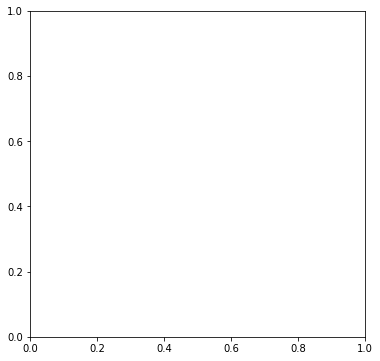

In [165]:
axis = plt.figure(figsize=(6,6))
sns.distplot( all_records , color="maroon", label="All Users",bins=100,kde=False)
plt.legend()
plt.plot([0.5, 0.5], [0, 800],'k--')
plt.ylabel("Number of Users")
plt.xlabel("Probability to Churn")
plt.title("User's likelihood to Churn")
plt.show()

In [144]:
df_friends_big.loc[df_friends_big['steamid'] == 76561197960265730,'Prob_Churned'].to_list()[0]

0.8220235885582673

In [145]:
n = 0

In [146]:
import json
json = json.dumps(as_dict)
f = open("SteamChurn_200k.json","w")
f.write(json)
f.close()

NameError: name 'as_dict' is not defined

In [ ]:
df_friends_small.set_index('steamid').to_csv('SteamChurn_200k.csv')

In [ ]:
as_dict.keys()

In [ ]:
axis = plt.figure(figsize=(6,6))
sns.distplot( list(map(lambda x: x*100, list(as_dict.get('Prob_Churned').values()))) , color="maroon", label="All Users",bins=100,kde=False)
plt.legend()
plt.plot([0.5, 0.5], [0, 800],'k--')
plt.ylabel("Number of Users")
plt.xlabel("Probability to Churn")
plt.title("User's likelihood to Churn")
plt.show()

In [193]:
df_full_prof['lastlogoff'].map(lambda x: 1 if (pd.to_datetime(x, unit='s') < churn_cutoff) else 0).sum()

27465

In [194]:
list_churn_by_month = {}
api_calls_day = pd.Timestamp('2019-06-13')
for i in range(0,12):
    churn_cutoff = api_calls_day - pd.Timedelta(i,'M')
    list_churn_by_month[i] = df_full_prof['lastlogoff'].map(lambda x: 1 if (pd.to_datetime(x, unit='s') < churn_cutoff) else 0).sum()
print(list_churn_by_month)

{0: 78930, 1: 36823, 2: 30975, 3: 27465, 4: 24872, 5: 22707, 6: 20898, 7: 19597, 8: 18536, 9: 17540, 10: 16616, 11: 15690}


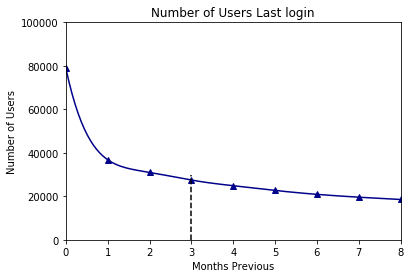

In [195]:

from scipy.interpolate import make_interp_spline, BSpline

lists = sorted(list_churn_by_month.items()) # sorted by key, return a list of tuples

x, y = zip(*lists) # unpack a list of pairs into two tuples

x = np.array(x)
y = np.array(y)
xnew = np.linspace(x.min(),x.max(),300)
spl = make_interp_spline(x, y, k=5)
y_smooth = spl(xnew)

plt.plot(xnew, y_smooth,color='darkblue')
plt.plot(x,y,color='darkblue',marker='^',linestyle='None')
plt.xlim([0, 8])
plt.ylim([0, 100000])
plt.plot([3, 3], [0, 30000],'k--')
plt.ylabel("Number of Users")
plt.xlabel("Months Previous")
plt.title("Number of Users Last login")
plt.show()

In [ ]:
sns.pairplot(df_friends_big[['Prob_Churned','num_Friends','isChurned']][df_friends_big['num_Friends'] == 1],hue='isChurned')

In [ ]:
sns.distplot(df_friends_big['isChurned_friends_mean'][df_friends_big['num_Friends'] != 0],kde=False)

In [ ]:
df_friends_big['inClan_friends_mean'].describe()